In [1]:
! pip install torcheval -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.4 MB/s eta 0:00:00a 0:00:01


In [32]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torch import optim, nn
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_accuracy, multiclass_confusion_matrix
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy
import numpy as np
import sklearn
from sklearn import metrics
import timm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

In [4]:
print(numpy.__version__)
print(torch.__version__)
print(timm.__version__)
print(sklearn.__version__)
print(matplotlib.__version__)

1.26.4
2.5.1+cu124
1.0.14
1.2.2
3.7.5


In [5]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
transform = transforms.Compose([
    # normalized dataset yielded worse results
    transforms.ToTensor(),
])

In [ ]:
batch_size = 64

train_dataset = datasets.FashionMNIST(root="dataset/", download=True, train=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.FashionMNIST(root="dataset/", download=True, train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
tensor, label = train_dataset[248]
img = to_pil_image(tensor)
img

In [9]:
def train(model, dataloader):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}: "):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        
        train_loss = running_loss / train_loader.dataset.__len__()
        train_losses.append(train_loss)

        train_acc = multiclass_accuracy(outputs, labels)
        train_accs.append(train_acc)

        print(f"Loss: {train_loss} \t Accuracy: {train_acc}")

In [10]:
def test_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = multiclass_accuracy(all_preds, all_labels)
    conf_matrix = multiclass_confusion_matrix(all_labels, all_preds, num_classes=10)
    print(f"Test Accuracy: {acc} \n\n")
    print(conf_matrix)


In [11]:
def plot_train_metrics(accs, losses):
    accs = [acc.cpu().numpy() if hasattr(acc, "cpu") else acc for acc in train_accs]
    losses = [loss.cpu().numpy() if hasattr(loss, "cpu") else loss for loss in train_losses]

    plt.subplot(1, 2, 1)
    plt.title("Training Accuracy over Epochs")
    plt.plot(accs)

    plt.subplot(1, 2, 2)
    plt.title("Training Loss over Epochs")
    plt.plot(losses)

    plt.plot()

In [12]:
# finds the first Convolution layer
def find_first_conv(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            return name, module
    raise ValueError("No Conv2d layer found!")

In [13]:
# feature extractor for the Hybrid model
def extract_features(loader, model, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for image, label in loader:
            image = image.to(device)
            outputs = model(image)
            features.append(outputs.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(features), np.concatenate(labels) 

In [14]:
# same for all models
input_size = 28*28
num_classes = 10
lr = 1e-3
num_epochs = 10

# 1st Model (Regular CNN)

In [51]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(3136, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x
        

In [52]:
model = ConvNet(in_channels=1, num_classes=num_classes).to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [54]:
train_losses, train_accs = [], []

train(model, train_loader)

Epoch 1: 100%|██████████| 938/938 [00:07<00:00, 128.86it/s]


Loss: 1.3474621567726135 	 Accuracy: 0.625


Epoch 2: 100%|██████████| 938/938 [00:07<00:00, 130.18it/s]


Loss: 0.6070957017262777 	 Accuracy: 0.71875


Epoch 3: 100%|██████████| 938/938 [00:07<00:00, 129.33it/s]


Loss: 0.5120835248947143 	 Accuracy: 0.90625


Epoch 4: 100%|██████████| 938/938 [00:07<00:00, 129.95it/s]


Loss: 0.4648202672481537 	 Accuracy: 0.84375


Epoch 5: 100%|██████████| 938/938 [00:07<00:00, 130.57it/s]


Loss: 0.43261378657023114 	 Accuracy: 0.84375


Epoch 6: 100%|██████████| 938/938 [00:07<00:00, 130.75it/s]


Loss: 0.4119262894630432 	 Accuracy: 0.875


Epoch 7: 100%|██████████| 938/938 [00:07<00:00, 129.74it/s]


Loss: 0.3946694406668345 	 Accuracy: 0.90625


Epoch 8: 100%|██████████| 938/938 [00:07<00:00, 130.61it/s]


Loss: 0.3798305114110311 	 Accuracy: 0.9375


Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 131.53it/s]


Loss: 0.3690635081926982 	 Accuracy: 0.90625


Epoch 10: 100%|██████████| 938/938 [00:07<00:00, 130.85it/s]

Loss: 0.355973952070872 	 Accuracy: 0.875


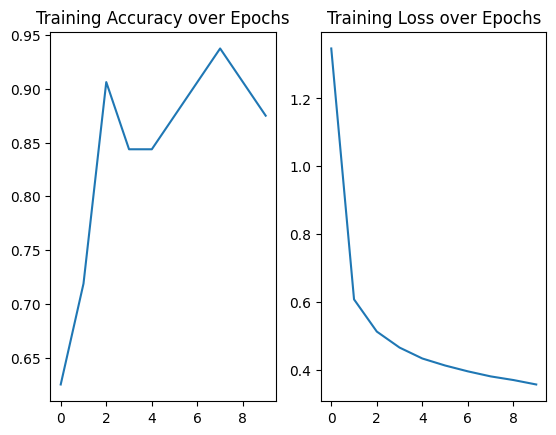

In [55]:
plot_train_metrics(train_losses, train_accs)

In [56]:
test_model(model, test_loader)

Test Accuracy: 0.8662999868392944 


tensor([[888,   3,  24,  38,   1,   1, 228,   0,   8,   0],
        [  0, 967,   1,  10,   1,   0,   1,   0,   1,   0],
        [ 14,   1, 772,  11,  41,   0,  82,   0,   3,   0],
        [ 40,  22,  13, 868,  24,   1,  27,   0,   4,   0],
        [ 11,   2, 148,  49, 896,   0, 184,   0,   5,   0],
        [  3,   0,   0,   0,   0, 953,   2,  28,   3,   9],
        [ 31,   3,  40,  22,  34,   0, 462,   0,   4,   1],
        [  0,   0,   0,   0,   0,  28,   0, 931,   3,  32],
        [ 13,   2,   2,   2,   3,   1,  14,   1, 968,   0],
        [  0,   0,   0,   0,   0,  16,   0,  40,   1, 958]], device='cuda:0')


# 2nd Model (Layer-Optimized CNN)

In [61]:
class ConvNetOptim(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ConvNetOptim, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(3136, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x
        

In [62]:
model = ConvNetOptim(in_channels=1, num_classes=num_classes).to(device)

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [64]:
train_losses, train_accs = [], []

train(model, train_loader)

Epoch 1: 100%|██████████| 938/938 [00:07<00:00, 122.75it/s]


Loss: 0.5518040292739869 	 Accuracy: 0.875


Epoch 2: 100%|██████████| 938/938 [00:07<00:00, 122.85it/s]


Loss: 0.3631230300585429 	 Accuracy: 0.9375


Epoch 3: 100%|██████████| 938/938 [00:07<00:00, 123.25it/s]


Loss: 0.321375837858518 	 Accuracy: 0.8125


Epoch 4: 100%|██████████| 938/938 [00:07<00:00, 121.64it/s]


Loss: 0.29708358644644417 	 Accuracy: 0.8125


Epoch 5: 100%|██████████| 938/938 [00:07<00:00, 123.40it/s]


Loss: 0.2809792355298996 	 Accuracy: 0.78125


Epoch 6: 100%|██████████| 938/938 [00:07<00:00, 124.32it/s]


Loss: 0.2650939870476723 	 Accuracy: 0.8125


Epoch 7: 100%|██████████| 938/938 [00:07<00:00, 123.32it/s]


Loss: 0.25779958974917727 	 Accuracy: 0.9375


Epoch 8: 100%|██████████| 938/938 [00:07<00:00, 121.16it/s]


Loss: 0.2462229454636574 	 Accuracy: 0.90625


Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 122.77it/s]


Loss: 0.2387523413578669 	 Accuracy: 0.96875


Epoch 10: 100%|██████████| 938/938 [00:07<00:00, 123.22it/s]

Loss: 0.23139338211218516 	 Accuracy: 0.90625


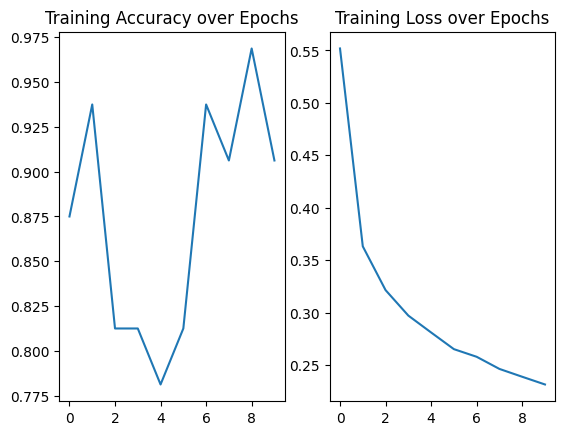

In [65]:
plot_train_metrics(train_losses, train_accs)

In [66]:
test_model(model, test_loader)

Test Accuracy: 0.903499960899353 


tensor([[912,   2,  21,  26,   2,   0, 177,   0,   4,   0],
        [  0, 972,   1,   2,   2,   0,   1,   0,   1,   0],
        [ 20,   2, 902,  16,  78,   0,  95,   0,   1,   0],
        [ 14,  18,  10, 921,  36,   0,  32,   0,   4,   0],
        [  6,   4,  42,  19, 864,   0,  96,   0,   3,   0],
        [  0,   0,   0,   0,   0, 963,   0,   5,   1,   4],
        [ 39,   1,  23,  16,  18,   0, 588,   0,   1,   1],
        [  0,   0,   0,   0,   0,  28,   0, 982,   5,  44],
        [  9,   1,   1,   0,   0,   0,  11,   0, 980,   0],
        [  0,   0,   0,   0,   0,   9,   0,  13,   0, 951]], device='cuda:0')


# 3rd Model (Pre-Trained Model)

In [67]:
class PretrainedClassifier(nn.Module):
    def __init__(self, arch, out_size, num_classes):
        super(PretrainedClassifier, self).__init__()
        self.base_model = timm.create_model(arch, pretrained=True)

        # re-initializing the first layer to fit grayscale data
        conv_name, rgb_conv = find_first_conv(self.base_model)
        grayscale_conv = nn.Conv2d(
            in_channels=1,
            out_channels=rgb_conv.out_channels,
            kernel_size=rgb_conv.kernel_size,
            stride=rgb_conv.stride,
            padding=rgb_conv.padding,
            bias=rgb_conv.bias is not None
        )

        with torch.no_grad():
            grayscale_conv.weight[:] = rgb_conv.weight.mean(dim=1, keepdim=True)
            if rgb_conv.bias is not None:
                grayscale_conv.bias[:] = rgb_conv.bias

        parent_module = self.base_model
        name_parts = conv_name.split('.')
        for part in name_parts[:-1]:
            parent_module = getattr(parent_module, part)
        setattr(parent_module, name_parts[-1], grayscale_conv)        

        # removing the last layer (classifier) and replacing with a randomly initialized one
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        self.out_size = out_size 
        self.classifier = nn.Linear(self.out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        out = self.classifier(x)
        return out

In [68]:
arch = "efficientnet_b0"
out_size = 1280   # default output size for efficientnet_b0
model = PretrainedClassifier(arch=arch, out_size=out_size, num_classes=num_classes)
model.to(device)
print(f"{arch} model has beed loaded into {device}")

efficientnet_b0 model has beed loaded into cuda


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [25]:
train_losses, train_accs = [], []

train(model, train_loader)

Epoch 1: 100%|██████████| 938/938 [00:35<00:00, 26.79it/s]


Loss: 0.7680823383490245 	 Accuracy: 0.9375


Epoch 2: 100%|██████████| 938/938 [00:33<00:00, 28.13it/s]


Loss: 0.38973962213993074 	 Accuracy: 0.9375


Epoch 3: 100%|██████████| 938/938 [00:33<00:00, 28.00it/s]


Loss: 0.3157310547669729 	 Accuracy: 0.8125


Epoch 4: 100%|██████████| 938/938 [00:33<00:00, 28.01it/s]


Loss: 0.2761333970546722 	 Accuracy: 0.875


Epoch 5: 100%|██████████| 938/938 [00:33<00:00, 28.00it/s]


Loss: 0.2431240194519361 	 Accuracy: 0.875


Epoch 6: 100%|██████████| 938/938 [00:33<00:00, 28.10it/s]


Loss: 0.22545449806451798 	 Accuracy: 0.875


Epoch 7: 100%|██████████| 938/938 [00:33<00:00, 28.14it/s]


Loss: 0.20540537987152735 	 Accuracy: 0.90625


Epoch 8: 100%|██████████| 938/938 [00:33<00:00, 27.97it/s]


Loss: 0.19075715660651524 	 Accuracy: 0.90625


Epoch 9: 100%|██████████| 938/938 [00:33<00:00, 28.10it/s]


Loss: 0.17497142231067023 	 Accuracy: 0.9375


Epoch 10: 100%|██████████| 938/938 [00:33<00:00, 28.05it/s]

Loss: 0.1650659002184868 	 Accuracy: 0.96875


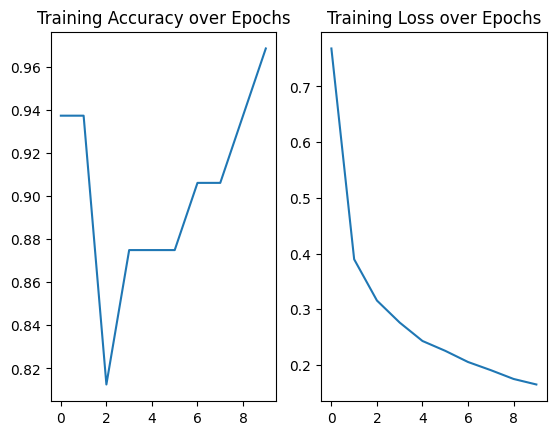

In [26]:
plot_train_metrics(train_accs, train_losses)

In [27]:
test_model(model, test_loader)

Test Accuracy: 0.915399968624115 


tensor([[862,   0,  12,  19,   1,   0, 125,   0,   2,   0],
        [  2, 978,   0,   6,   1,   0,   1,   0,   0,   0],
        [ 15,   1, 902,  10,  53,   0,  68,   0,   2,   0],
        [ 16,  15,  11, 908,  22,   0,  17,   0,   3,   0],
        [  3,   2,  34,  19, 867,   0,  67,   0,   2,   0],
        [  0,   0,   0,   0,   0, 985,   0,   8,   1,   3],
        [ 98,   3,  39,  36,  55,   0, 720,   0,   3,   0],
        [  1,   0,   0,   0,   0,  10,   0, 977,   1,  27],
        [  3,   1,   2,   2,   1,   2,   2,   0, 986,   1],
        [  0,   0,   0,   0,   0,   3,   0,  15,   0, 969]], device='cuda:0')


## 4th Model (Hybrid) : CNN as Feature Extractor + SVM

In [15]:
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.identity = nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.identity(x)
        return x
        

In [ ]:
feature_extractor = FeatureExtractor(in_channels=1, num_classes=num_classes)
feature_extractor.to(device)

In [17]:
# Extract Features

train_features, train_labels = extract_features(train_loader, feature_extractor, device)
test_features, test_labels = extract_features(test_loader, feature_extractor, device)

In [18]:
np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_labels)
np.save("test_features.npy", test_features)
np.save("test_labels.npy", test_labels)

train_features = np.load("train_features.npy")
train_labels = np.load("train_labels.npy")
test_features = np.load("test_features.npy")
test_labels = np.load("test_labels.npy")

In [19]:
clf = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial')  # fast & scalable
clf.fit(train_features, train_labels)

LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

In [23]:
y_pred = clf.predict(test_features)
acc = accuracy_score(test_labels, y_pred)
acc

0.8698

In [24]:
preds = clf.predict(test_features)

In [29]:
acc = accuracy_score(preds, test_labels)
conf_matrix = confusion_matrix(test_labels, preds)
print(f"Test Accuracy: {acc} \n\n")
print(conf_matrix)

Test Accuracy: 0.8698 


[[836   0  17  44   9   4  79   0  11   0]
 [  2 960   5  22   4   0   4   0   3   0]
 [ 13   0 802  12  97   1  69   0   6   0]
 [ 22   7   9 882  29   1  46   0   4   0]
 [  1   1  84  32 809   0  69   0   4   0]
 [  0   0   0   2   0 945   0  38   1  14]
 [149   0  91  32  97   0 609   0  22   0]
 [  0   0   0   0   0  17   0 947   1  35]
 [  2   1   4   6   4   4  14   5 960   0]
 [  0   0   0   1   0   6   1  43   1 948]]


In [31]:
# Train accuracy
y_train_pred = clf.predict(train_features)
train_acc = accuracy_score(train_labels, y_train_pred)
train_acc

0.8825166666666666

In [33]:
# Train loss
y_train_proba = clf.predict_proba(train_features)
train_loss = log_loss(train_labels, y_train_proba)
train_loss

0.35411471061704797